In [1]:
import cv2
import numpy
import matplotlib.pyplot as plt

In [2]:
from skimage import io
from skimage.transform import resize
from skimage import img_as_ubyte
from skimage.color import *
from skimage.util import *

In [3]:
from pandas import DataFrame

In [4]:
def is_low_contrast(obj_image, 
                    fraction_threshold, 
                    lower_percentile,
                    upper_percentile, 
                    method='linear'):
    
    dlimits = dtype_limits(obj_image, clip_negative=False)
    limits = numpy.percentile(obj_image, 
                              [lower_percentile, upper_percentile])
    
    ratio = (limits[1] - limits[0]) / (dlimits[1] - dlimits[0])

    return ratio < fraction_threshold, ratio

In [5]:
def is_low_contrast_image(obj_image, fraction_threshold=0.2, lower_percentile=10, upper_percentile=90):
    low_contrast = False

    low_contrast = is_low_contrast(obj_image, 
                                   fraction_threshold=fraction_threshold, 
                                   lower_percentile=lower_percentile, 
                                   upper_percentile=upper_percentile)
    return low_contrast

In [45]:
def get_contrast_slope_ratios(obj_image, fraction_threshold=0.2):
    obj_flatX = obj_image.flatten()
    
    ratio = numpy.diff(obj_flatX)
    ratio = (ratio[1:] - ratio[1:].min()) / (ratio[1:].max() - ratio[1:].min())

    ratio = ratio[ratio > fraction_threshold]
    ratioX = numpy.unique(ratio)  

    obj_flatY = numpy.transpose(obj_image).flatten()
    
    ratio = numpy.diff(obj_flatY)
    ratio = (ratio[1:] - ratio[1:].min()) / (ratio[1:].max() - ratio[1:].min())

    ratio = ratio[ratio > fraction_threshold]
    ratioY = numpy.unique(ratio)  

    return [ratioX, ratioY]

<h3>環境設置</h3>

In [7]:
image_url = [
    'https://cloudfront-ap-southeast-2.images.arcpublishing.com/nzme/I76JV6CC7AXAH3MDGINDSH5ZKM.jpg',
    'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS967Q5MfU_vKKmwfcyAo3cMvwxV24YaE_Rgg&usqp=CAU',
    'https://res.cloudinary.com/dk-find-out/image/upload/q_80,w_1920,f_auto/DCTM_Penguin_UK_DK_AL644648_p7nd0z.jpg',
    'https://www.aqueon.com/-/media/Images/Aqueon-NA/US/Assets/Care-Sheets/monoargentus-brackish_600x400.png'
]

In [8]:
io.use_plugin('matplotlib')

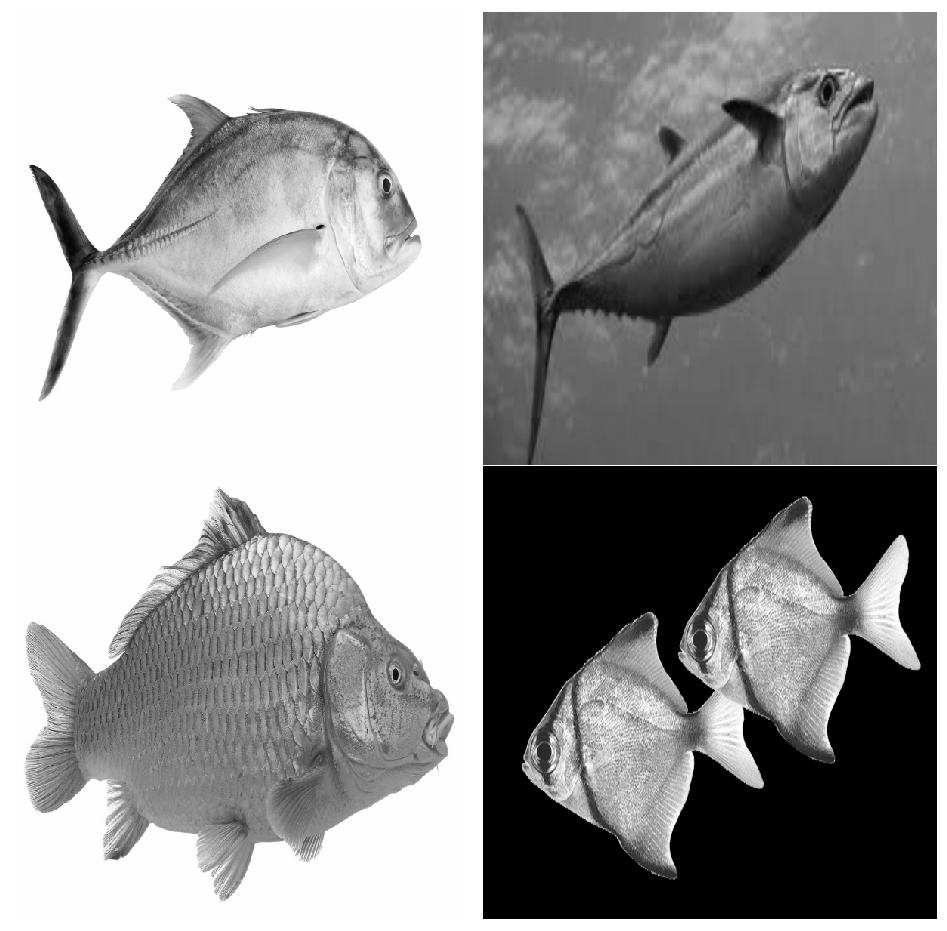

In [9]:
my_image_list = []

fig, ax = plt.subplots(dpi=120, figsize=(8, 8), nrows=2, ncols=2)

for row in range(2):
    for col in range(2):
        my_image = io.imread(image_url[row * 2 + col])   
        my_image = resize(my_image, (600, 600, 1), anti_aliasing=True)
        
        _image = my_image

        if my_image.shape[2] == 4:
            _image = rgb2gray(rgba2rgb(img_as_ubyte(my_image)))
        elif my_image.shape[2] == 3:
            _image = rgb2gray(img_as_ubyte(my_image))

        my_image_list.append(img_as_ubyte(_image))
        
        io.imshow(_image, ax=ax[row][col], interpolation='nearest')
        ax[row][col].axis('off')

plt.tight_layout()
plt.show()

<h3>邊界處裡</h3>

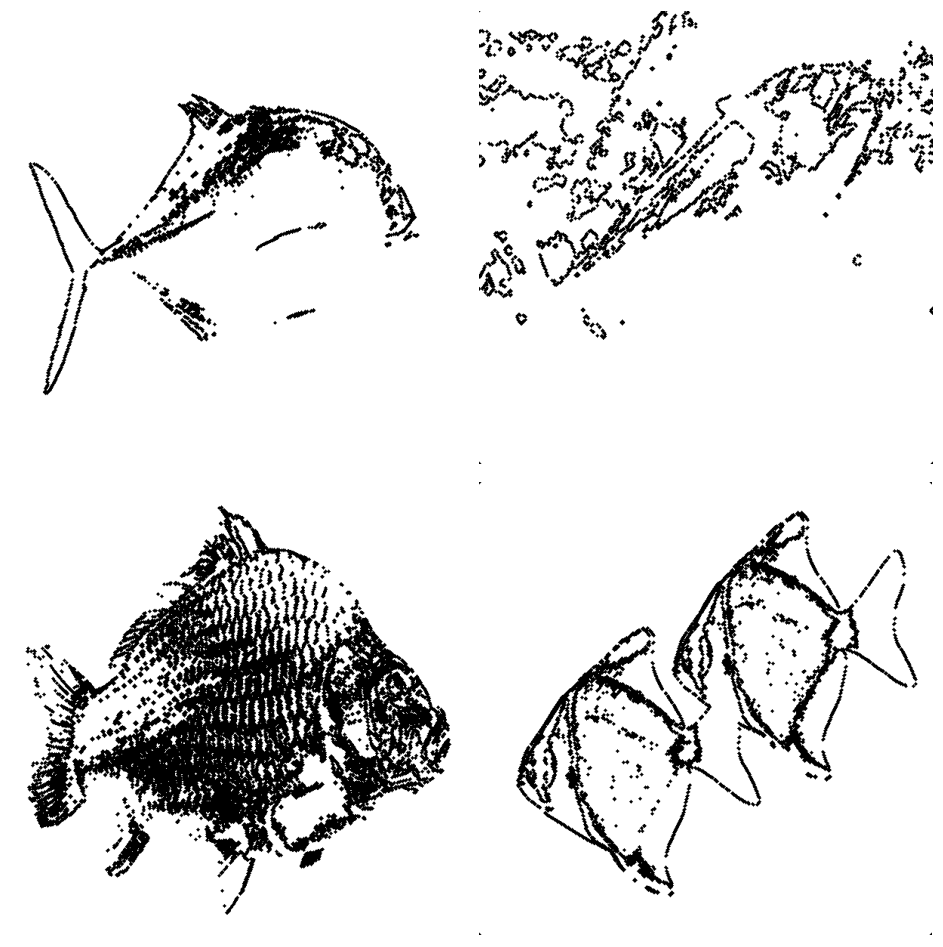

In [10]:
my_countour_list = []
my_contour_image_list = []

img_blank = numpy.ones(my_image_list[0].shape, numpy.uint8)

fig, ax = plt.subplots(dpi=120, figsize=(8, 8), nrows=2, ncols=2)

for row in range(2):
    for col in range(2):
        my_image = my_image_list[row * 2 + col]   
        
        ret, thresh = cv2.threshold(my_image, 127, 255, cv2.THRESH_BINARY_INV)
        contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        
        my_countour_list.append(contours)
        
        _image = img_blank.copy()

        for contour in contours:
            cv2.drawContours(_image, contour, -1, (0, 0, 255), 3)
      
        ax[row][col].imshow(_image, cmap='gray')
        ax[row][col].axis('off')
        
        my_contour_image_list.append(_image)

plt.tight_layout()
plt.show()

<h3>邊界直方圖均衡化處裡</h3>

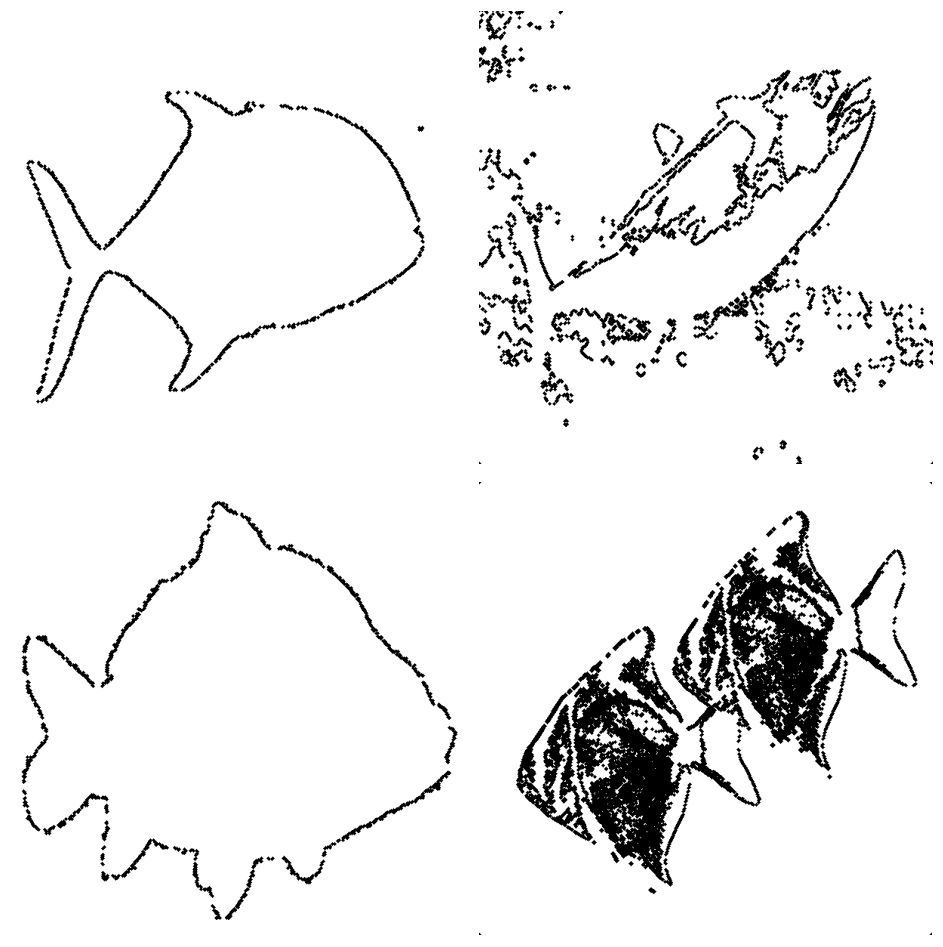

In [20]:
my_countour_list = []
img_blank = numpy.ones(my_image_list[0].shape, numpy.uint8)

fig, ax = plt.subplots(dpi=120, figsize=(8, 8), nrows=2, ncols=2)

for row in range(2):
    for col in range(2):
        my_image = my_image_list[row * 2 + col]          
        my_image = cv2.equalizeHist(my_image.copy())

        ret, thresh = cv2.threshold(my_image, 127, 255, cv2.THRESH_BINARY_INV)
        contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        
        my_countour_list.append(contours)
        
        _image = img_blank.copy()

        for contour in contours:
            cv2.drawContours(_image, contour, -1, (0, 0, 255), 3)

        ax[row][col].imshow(_image, cmap='gray')
        ax[row][col].axis('off')

plt.tight_layout()
plt.show()

In [21]:
for source_image in my_image_list:
    print(is_low_contrast_image(source_image, fraction_threshold=0.3))

(False, 0.403921568627451)
(True, 0.2901960784313726)
(False, 0.5607843137254902)
(False, 0.7490196078431373)


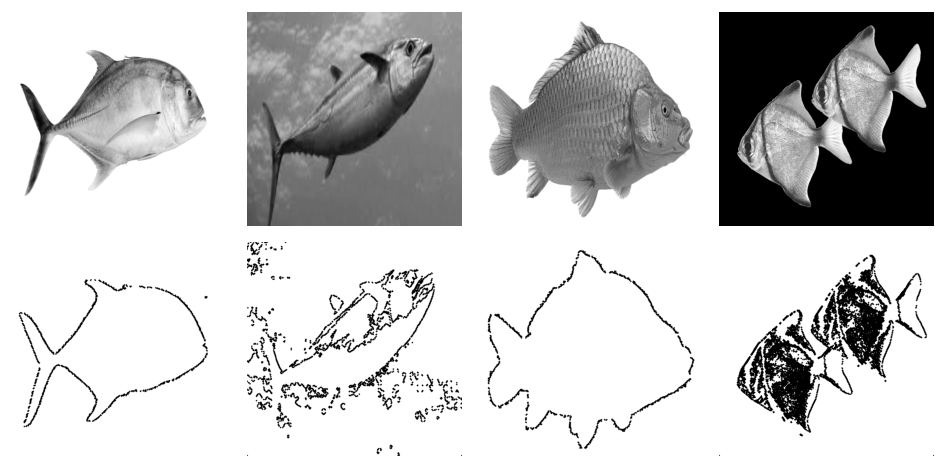

In [42]:
fig, ax = plt.subplots(dpi=120, figsize=(8, 4), nrows=2, ncols=4, sharey=True)

for col in range(4):
    _image = my_image_list[col]          
    ax[0][col].imshow(_image, cmap='gray')
    ax[0][col].axis('off')

for col in range(4):
    my_image = my_image_list[col]          

    my_image = cv2.equalizeHist(my_image.copy())

    ret, thresh = cv2.threshold(my_image, 127, 255, cv2.THRESH_BINARY_INV)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    my_countour_list.append(contours)

    _image = img_blank.copy()

    for contour in contours:
        cv2.drawContours(_image, contour, -1, (0, 0, 255), 3)

    ax[1][col].imshow(_image, cmap='gray')
    ax[1][col].axis('off')

plt.tight_layout()
plt.show()

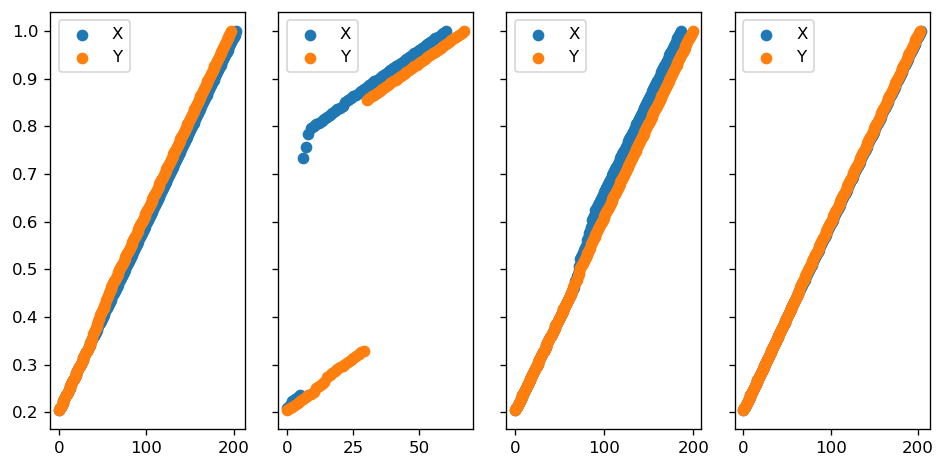

In [48]:
fig, ax = plt.subplots(dpi=120, figsize=(8, 4), ncols=4, sharey=True)

for col in range(4):
    my_image = my_image_list[col]          

    ratio = get_contrast_slope_ratios(my_image)

    ratioX = numpy.unique(ratio[0])
    ratioX = numpy.sort(ratioX)

    ratioY = numpy.unique(ratio[1])
    ratioY = numpy.sort(ratioY)
    
    ax[col].scatter(numpy.arange(len(ratioX)), ratioX, label='X')
    ax[col].scatter(numpy.arange(len(ratioY)), ratioY, label='Y')

    ax[col].legend(loc='best')

plt.tight_layout()
plt.show()